In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# TEDtalk Topics

Today's task is to arrive at a reasonable topic model for the Tedtalk corpus. There is, as yet, no consensus on arriving at `k`, and so we are going to start with 50 and 100 topics to see what the comparison might be. It's possible 200 topics might be called for, but Jonathan Goodwin and I used 50 topics for 8000 articles, though that was in a disciplinary-specific domain.

The first thing to do is to use `pandas` to read the `csv` with the texts inside -- I will need a way to attach a useful name to each text by the time this work is done. (Note: I am importing all the talks here. If we want to test, we should train on talks from 2006 - 2015, then test on 2016. Or something like that.)

In [2]:
import pandas
colnames = ['author', 'title', 'date' , 'length', 'text']
data = pandas.read_csv('./data/talks-v1b.csv', names=colnames)
talks = data.text.tolist()

A `len(talks)` shows that we've got a list of 2113 strings, and typing in a random number, `talk[#]` gives me the contents of a talk. It also revealed that some talks, for whatever reason, have no content. A quick script from Katherine gave us a way to find those strings. (The content of those strings is `'n'`, e.g. `talk[185]`.

In [4]:
i = 0
no_good = []
for talk in talks: 
    A = type(talk)
    B = type('string or something')
    if A != B:
        no_good.append(i)
    i = i + 1
    
print(no_good)

[185, 398, 513, 877, 1015, 1100, 2011]


The next bit of scripting, first, removes the `empty` talks but does so in reverse order in order to avoid disturbing the index order -- n.b., if we re-associate labels from elsewhere in the CSV, we will need to remove the same rows from that list as well.

After purging, we check to see that we are indeed "seven down" and then we re-check for empty strings. The result is an empty list. Good.

In [5]:
for index in sorted(no_good, reverse=True):
    del talks[index]
    
print(len(talks))

# Re-checking for anything NOT a string
i = 0
still_no_good = []
for talk in talks: 
    A = type(talk)
    B = type('string or something')
    if A != B:
        still_no_good.append(i)
    i = i + 1

print(still_no_good)

2106
[]


## Topic Models

We will start with `gensim` because I have used it before, but I am curious about `SciKit` and may try it over the weekend.

In [6]:
from stop_words import get_stop_words
from gensim import corpora, models, similarities

# remove common words and tokenize
stoplist = set(get_stop_words('en'))
texts = [[word for word in talk.lower().split() if word not in stoplist]
         for talk in talks]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [9]:
dictionary = corpora.Dictionary(texts)
dictionary.save('./data/talks.dict')

In [10]:
print(dictionary)
# To see the assignments for the tokens:
# print(dictionary.token2id)

Dictionary(47144 unique tokens: ['evaporating.', 'measure.', 'sensation.', 'exciting.', 'irresponsibility']...)


In [11]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('./data/talks.mm', corpus) # Save corpus in Market Matrix format

# To load this corpus: corpus = corpora.MmCorpus('./data/talks.mm')

In [12]:
corpora.BleiCorpus.serialize('./data/talks.lda-c', corpus) # To save in LDA-C format

In [15]:
tfidf = models.TfidfModel(corpus) # to train a portion of the corpus

In [16]:
corpus_tfidf = tfidf[corpus] # to transform the entire corpus

We have a lot of variables/objects in play. I just need a quick reminder of what we have so far. 

In [14]:
whos

Variable         Type           Data/Info
-----------------------------------------
A                type           <class 'str'>
B                type           <class 'str'>
MODELS_DIR       str            /path/to/models/dir
NUM_TOPICS       int            5
colnames         list           n=5
corpora          module         <module 'gensim.corpora' <...>sim/corpora/__init__.py'>
corpus           list           n=2106
data             DataFrame                               <...>\n[2113 rows x 5 columns]
defaultdict      type           <class 'collections.defaultdict'>
dictionary       Dictionary     Dictionary(47144 unique t<...>, 'irresponsibility']...)
frequency        defaultdict    defaultdict(<class 'int'><...>erkin': 2, 'flimsy.': 1})
gensim           module         <module 'gensim' from '/o<...>ages/gensim/__init__.py'>
get_stop_words   function       <function get_stop_words at 0x10debeea0>
i                int            2106
index            int            185
logging    

The next series of steps are from [Sujit Pal](http://sujitpal.blogspot.com/2014/08/topic-modeling-with-gensim-over-past.html) (blockquoted to make sure we know who wrote what).

> I didn't know (and didn't have an opinion about) how many topics this corpus should yield so I decided to compute this by reducing the features to two dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. Gensim offers various transforms that allow us to project the vectors in a corpus to a different coordinate space. One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 2D.

In [18]:
# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

# write out coordinates to file
fcoords = open("./data/coords.csv", 'w', newline='')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

> Next I clustered the points in the reduced 2D LSI space using KMeans, varying the number of clusters (K) from 1 to 10. The objective function used is the Inertia of the cluster, defined as the sum of squared differences of each point to its cluster centroid. This value is provided directly from the [Scikit-Learn KMeans algorithm][skk]. Other popular functions include Distortion (Inertia divided by the number of points) or the Percentage of Variance Explained, as described on this [StackOverflow post][so].

[skk]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
[so]: http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means

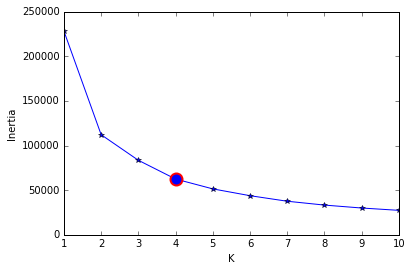

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_max = 10

coords = np.loadtxt("./data/coords.csv", delimiter="\t")
ks = range(1, k_max + 1)

inertias = np.zeros(k_max)
diff = np.zeros(k_max)
diff2 = np.zeros(k_max)
diff3 = np.zeros(k_max)
for k in ks:
    kmeans = KMeans(k).fit(coords)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

> I plotted the Inertias for different values of K, then used Vincent Granville's approach of calculating the third differential to find an [elbow point][ep]. The elbow point happens here for K=5 and is marked with a red dot in the graph below.

[ep]: http://radimrehurek.com/2014/03/data-streaming-in-python-generators-iterators-iterables/

> I then re-ran the KMeans algorithm with K=5 and generated the clusters.

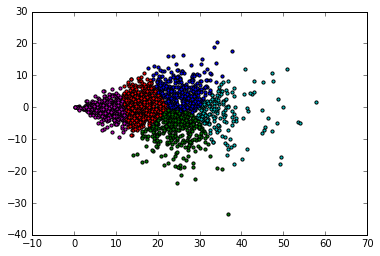

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n_topics = 5

X = np.loadtxt("./data/coords.csv", delimiter="\t")
kmeans = KMeans(n_topics).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m", "c"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

> I then ran the full [LDA transform][ldat] against the BoW corpus, with the number of topics set to 5. As in LSI, I load up the corpus and dictionary from files, then apply the transform to project the documents into the LDA Topic space. Notice that LDA and LSI are conceptually similar in gensim - both are transforms that map one vector space to another.

[ldat]: http://radimrehurek.com/gensim/models/ldamodel.html

In [27]:
import gensim

n_topics = 25

# We are assuming that the dictionary and the corpus are still loaded.
# If not, uncomment these two lines to load them.
# dictionary = gensim.corpora.Dictionary.load('./data/talks.dict')
# corpus = gensim.corpora.MmCorpus('./data/talks.mm')

# Project to LDA space
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=n_topics)
lda.print_topics(n_topics)

['0.008*one + 0.006*going + 0.006*can + 0.006*like + 0.005*just + 0.005*people + 0.004*actually + 0.004*know + 0.004*now + 0.004*get',
 '0.010*people + 0.008*like + 0.008*can + 0.007*one + 0.006*think + 0.006*now + 0.005*actually + 0.005*just + 0.005*going + 0.005*really',
 '0.010*like + 0.009*can + 0.007*just + 0.007*people + 0.007*one + 0.006*really + 0.005*now + 0.005*time + 0.005*see + 0.004*us',
 '0.011*can + 0.008*just + 0.008*now + 0.006*like + 0.006*people + 0.006*one + 0.005*know + 0.005*penguins + 0.005*actually + 0.005*going',
 '0.009*can + 0.008*one + 0.007*going + 0.007*like + 0.006*people + 0.006*now + 0.005*know + 0.005*just + 0.005*think + 0.004*actually',
 '0.008*can + 0.008*one + 0.006*see + 0.005*like + 0.005*just + 0.005*now + 0.005*people + 0.004*actually + 0.004*know + 0.004*really',
 '0.010*can + 0.008*one + 0.007*like + 0.007*just + 0.007*now + 0.006*people + 0.005*going + 0.005*really + 0.004*see + 0.004*know',
 '0.007*people + 0.006*know + 0.005*like + 0.005*n

The results are as follows. As you can see, each topic is made up of a mixture of terms. The top 10 terms from each topic is shown in the output below and covers between 69-80% of the probability space for each topic.

In [ ]:
import os
import wordcloud

MODELS_DIR = "models"

final_topics = open(os.path.join(MODELS_DIR, "final_topics.txt"), 'rb')
curr_topic = 0
for line in final_topics:
    line = line.strip()[line.rindex(":") + 2:]
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    elements = wordcloud.fit_words(freqs, width=120, height=120)
    wordcloud.draw(elements, "gs_topic_%d.png" % (curr_topic),
                   width=120, height=120)
    curr_topic += 1
final_topics.close()